### Preprocessing Data

In [34]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
from itertools import islice

filename_infrastructure = 'data_unwrangled/Centerline.csv'
filename_collisions = 'data_unwrangled/Motor_Vehicle_Collisions_-_Crashes.csv'
filename_boundaries = 'data_unwrangled/2010 Neighborhood Tabulation Areas (NTAs).geojson'

In [40]:
infrastructure = pd.read_csv(filename_infrastructure)
infrastructure = gpd.GeoDataFrame(infrastructure)
infrastructure['the_geom'] = infrastructure['the_geom'].apply(shapely.wkt.loads)
infrastructure.set_geometry('the_geom', inplace=True)

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_34174/3234150003.py:1: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  infrastructure = pd.read_csv(filename_infrastructure)


In [41]:
filter = gpd.read_file(filename_boundaries)
filter = filter[filter['boro_name'] == 'Manhattan']

<AxesSubplot:>

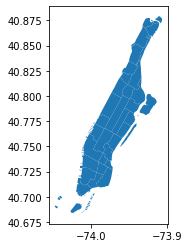

In [42]:
filter.plot()

In [43]:
infrastructure = infrastructure.sjoin(filter) # restrict streets to filter
if 'index_right' in infrastructure.columns:
    infrastructure.drop(columns=['index_right'], inplace=True)

/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


<AxesSubplot:>

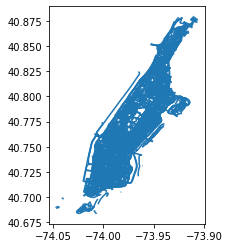

In [44]:
infrastructure.plot()

In [45]:
def get_neighbors(geometry, id):
    neighbors = infrastructure['PHYSICALID'].loc[infrastructure['the_geom'].intersects(geometry)].tolist()
    neighbors.remove(id)
    return neighbors

# Build column with adjacent links
# WARNING: Can only do on subset of data, otherwise it will take forever
infrastructure['neighbors'] = infrastructure.apply(lambda x: get_neighbors(x.the_geom, x.PHYSICALID), axis=1)

# Additional constraints like which way to turn, which roads meet at intersection

In [9]:
collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE'])

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_34174/1389750111.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE'])


In [10]:
mask = collisions['BOROUGH'].str.contains('bike') # placeholder
# other names: bk, bicycle, bycyc
for i in [1,2,3,4,5]:
    mask = mask | collisions[f'VEHICLE TYPE CODE {i}'].str.contains('bike', case=False)

# Restrict to collisions involving bikes
collisions = collisions.loc[mask]

In [11]:
collisions = gpd.GeoDataFrame(collisions, geometry=gpd.points_from_xy(collisions.LONGITUDE, collisions.LATITUDE))

In [12]:
collisions.sjoin(filter)
if 'index_right' in collisions.columns:
    collisions.drop(columns=['index_right'], inplace=True)

In [13]:
collisions = collisions.sjoin_nearest(infrastructure, max_distance=0.0001)

In [14]:
collisions['CRASH DATE'] = pd.to_datetime(collisions['CRASH DATE'])
collisions.groupby([collisions['CRASH DATE'].dt.year]).count()
## So let's start in 2016!

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SHAPE_Leng,neighbors
CRASH DATE,,,,,,,,,,,,,,,,,,,,,
2012,1,1,1,1,1,1,1,1,1,0,...,0,0,1,0,0,1,1,0,1,1
2013,1,1,1,1,1,1,1,0,0,1,...,1,0,1,0,0,1,1,0,1,1
2014,2,2,2,2,2,2,2,1,1,1,...,1,0,2,0,0,2,2,0,2,2
2015,1,1,1,1,1,1,1,1,1,0,...,1,0,1,0,0,1,1,0,1,1
2016,1013,1013,843,843,1013,1013,1013,719,590,294,...,455,68,894,16,4,1013,1013,467,1013,1013
2017,1192,1192,960,960,1192,1192,1192,816,599,376,...,511,63,1063,9,1,1192,1192,585,1192,1192
2018,1148,1148,976,976,1148,1148,1148,819,656,329,...,547,51,1039,13,0,1148,1148,517,1148,1148
2019,1166,1166,984,984,1166,1166,1166,795,622,371,...,523,64,1041,9,1,1166,1166,555,1166,1166
2020,751,751,633,633,751,751,751,521,413,230,...,355,24,693,5,3,751,751,343,751,751


In [15]:

start_date = pd.Timestamp('2016-01-01')
collisions = collisions.loc[collisions['CRASH DATE'] > start_date]

In [16]:
year = '2016'
month = '01'
filename_citibike = f'data_unwrangled/citibike/{year}{month}-citibike-tripdata.csv'
citibike_yearmonth = pd.read_csv(filename_citibike)

In [17]:
citibike_yearmonth = gpd.GeoDataFrame(citibike_yearmonth)
citibike_yearmonth['start_geom'] = gpd.points_from_xy(citibike_yearmonth['start station longitude'], citibike_yearmonth['start station latitude'])
citibike_yearmonth['end_geom'] = gpd.points_from_xy(citibike_yearmonth['end station longitude'], citibike_yearmonth['end station latitude'])

In [18]:
for geom in ['start_geom', 'end_geom']:
    citibike_yearmonth.set_geometry(geom, inplace=True)
    citibike_yearmonth = citibike_yearmonth.sjoin(filter)
    if 'index_right' in citibike_yearmonth.columns:
        citibike_yearmonth.drop(columns=['index_right'], inplace=True)


<AxesSubplot:>

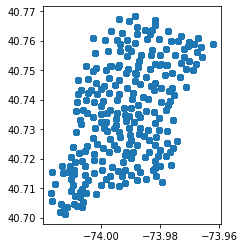

In [19]:
citibike_yearmonth.plot()
#len(citibike_yearmonth['start station id'].unique())

In [52]:
citibike_yearmonth['starttime'] = pd.to_datetime(citibike_yearmonth['starttime'])
citibike_yearmonth['starttime_rounded'] = citibike_yearmonth['starttime'].dt.floor('h')

In [59]:
citibike_yearmonth = citibike_yearmonth[citibike_yearmonth['tripduration'] <= 24 * 60 * 60]

In [21]:
len(citibike_yearmonth['end station id'].unique())

252

In [53]:
citibike_yearmonth

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,start_geom,end_geom,starttime_rounded
0,923,2016-01-01 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1,POINT (-73.99973 40.71911),POINT (-74.01576 40.71151),2016-01-01 00:00:00
1,379,2016-01-01 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1,POINT (-73.97966 40.74394),POINT (-73.98808 40.74855),2016-01-01 00:00:00
2,589,2016-01-01 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2,POINT (-74.00177 40.75066),POINT (-74.00264 40.73902),2016-01-01 00:00:00
3,889,2016-01-01 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2,POINT (-73.99973 40.71911),POINT (-74.01576 40.71151),2016-01-01 00:00:00
7,694,2016-01-01 00:02:18,1/1/2016 00:13:53,268,Howard St & Centre St,40.719105,-73.999733,497,E 17 St & Broadway,40.737050,-73.990093,15747,Subscriber,1996.0,1,POINT (-73.99973 40.71911),POINT (-73.99009 40.73705),2016-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509470,533,2016-01-31 23:57:16,2/1/2016 00:06:10,432,E 7 St & Avenue A,40.726218,-73.983799,223,W 13 St & 7 Ave,40.737815,-73.999947,23131,Subscriber,1988.0,1,POINT (-73.98380 40.72622),POINT (-73.99995 40.73782),2016-01-31 23:00:00
509472,326,2016-01-31 23:57:59,2/1/2016 00:03:26,476,E 31 St & 3 Ave,40.743943,-73.979661,379,W 31 St & 7 Ave,40.749156,-73.991600,20091,Subscriber,1983.0,1,POINT (-73.97966 40.74394),POINT (-73.99160 40.74916),2016-01-31 23:00:00
509475,356,2016-01-31 23:58:54,2/1/2016 00:04:51,441,E 52 St & 2 Ave,40.756014,-73.967416,501,FDR Drive & E 35 St,40.744219,-73.971212,24203,Subscriber,1990.0,1,POINT (-73.96742 40.75601),POINT (-73.97121 40.74422),2016-01-31 23:00:00
509476,1128,2016-01-31 23:59:13,2/1/2016 00:18:02,475,E 16 St & Irving Pl,40.735243,-73.987586,264,Maiden Ln & Pearl St,40.707065,-74.007319,24272,Subscriber,1990.0,1,POINT (-73.98759 40.73524),POINT (-74.00732 40.70706),2016-01-31 23:00:00


In [54]:
citibike_yearmonth.groupby([citibike_yearmonth['starttime_rounded'], citibike_yearmonth['start station id'], citibike_yearmonth['end station id']]).count()

tripduration  starttime  \
starttime_rounded   start station id end station id                            
2016-01-01 00:00:00 116              495                        1          1   
                    127              509                        1          1   
                    160              295                        1          1   
                    161              438                        1          1   
                    168              325                        1          1   
...                                                           ...        ...   
2016-01-31 23:00:00 2003             470                        1          1   
                    2009             355                        1          1   
                    2012             518                        1          1   
                    3002             525                        1          1   
                    3235             428                        1          1   

                                                     stoptime  \
starttime_rounded   start station id end station id             
2016-01-01 00:00:00 116              495                    1   
                    127              509                    1   
                    160              295                    1   
                    161              438                    1   
                    168              325                    1   
...                                                       ...   
2016-01-31 23:00:00 2003             470                    1   
                    2009             355                    1   
                    2012             518                    1   
                    3002             525                    1   
                    3235             428                    1   

                                                     start station name  \
starttime_rounded   start station id end station id                       
2016-01-01 00:00:00 116              495                              1   
                    127              509                              1   
                    160              295                              1   
                    161              438                              1   
                    168              325                              1   
...                                                                 ...   
2016-01-31 23:00:00 2003             470                              1   
                    2009             355                              1   
                    2012             518                              1   
                    3002             525                              1   
                    3235             428                              1   

                                                     start station latitude  \
starttime_rounded   start station id end station id                           
2016-01-01 00:00:00 116              495                                  1   
                    127              509                                  1   
                    160              295                                  1   
                    161              438                                  1   
                    168              325                                  1   
...                                                                     ...   
2016-01-31 23:00:00 2003             470                                  1   
                    2009             355                                  1   
                    2012             518                                  1   
                    3002             525                                  1   
                    3235             428                                  1   

                                                     start station longitude  \
starttime_rounded   start station id end station id                            
20

In [22]:
graph = nx.from_pandas_edgelist(infrastructure.explode('neighbors'), source='PHYSICALID', target='neighbors')

In [23]:
length = len(nx.shortest_path(graph, 29, 226))

In [24]:
k = 10
for path in list(islice(nx.shortest_simple_paths(graph, 29, 226), k)):
    print(path)
    print(len(path))

[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 132032, 1319, 227, 226]
24
[29, 79163, 131907, 131905, 131906, 131898, 131895, 131896, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 132032, 1319, 227, 226]
24
[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131996, 132002, 131998, 308, 132032, 1319, 227, 226]
24
[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 853, 228, 132031, 227, 226]
24
[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 176275, 132031, 227, 226]
24
[29, 173026, 131907, 131905, 131906, 131898, 131895, 131896, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 132032, 1319, 227, 226]
24
[2